In [21]:
import matplotlib.pyplot as plt
from scipy.io import readsav
import numpy as np
import copy
from helita.io import lp
from astropy.io import fits
import cv2
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, medial_axis, diamond, binary_opening, binary_closing
from skimage.exposure import rescale_intensity
import seaborn as sns
import math
import matplotlib.patches as mpatches

In [3]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap
mycmap = transparent_cmap(plt.cm.Blues)

In [4]:
dpath = '/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/crispex/09:12:00/'
dpath_area = '/mn/stornext/d9/souvikb/K_means_results/savefiles/'
dpath_cluster_fits= '/mn/stornext/d9/souvikb/K_means_results/'
dpath_timesteps ='/mn/stornext/d11/lapalma/reduc/2017/2017-05-25/CHROMIS/calib_tseries/'

In [5]:
cluster_mask = fits.getdata(dpath_cluster_fits+'clusters_mask.fits',ext=0)# Reading the Cluster mask time series

In [6]:
#Labelling the clusters in 3D by considering all the structures. 
cluster_interest_blue = [12,48,49,25] 
master_aux_cube_blue=cluster_mask*0
for clust_index in range(len(cluster_interest_blue)):
    master_aux_cube_blue[np.where(cluster_mask == cluster_interest_blue[clust_index])] = 1.

In [7]:
# Morphological operations as discussed so as to avoid the 1 pixel like connectivities.
# So, we decided to perform morph_open followed by morph_close
selem = diamond(1)
morph_processed_blue = master_aux_cube_blue*0.
for scan in range(425):
    morph_processed_blue[:,:,scan] = binary_closing(binary_opening(master_aux_cube_blue[:,:,scan],selem),selem) # Morph_open followed by Morph_closing operation to get rid of the salt

In [8]:
hdrH_im =lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
hdrH_sp = lp.getheader(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath+'crispex_6563_08:05:00_aligned_3950_2017-05-25T09:12:00_scans=0-424_rotated2iris.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])

In [13]:
cubeH = np.swapaxes(cubeH,0,1)

In [14]:
cubeH.shape

(1641, 1518, 425, 32)

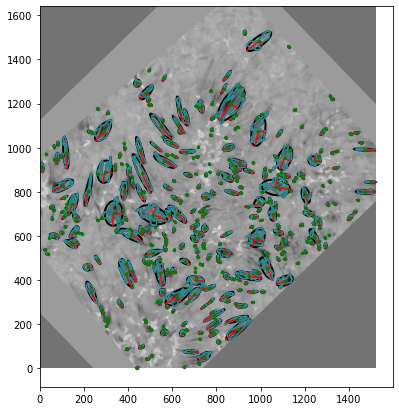

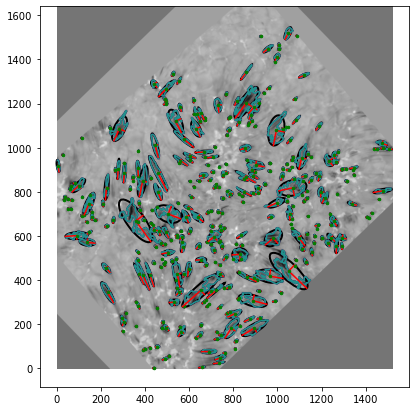

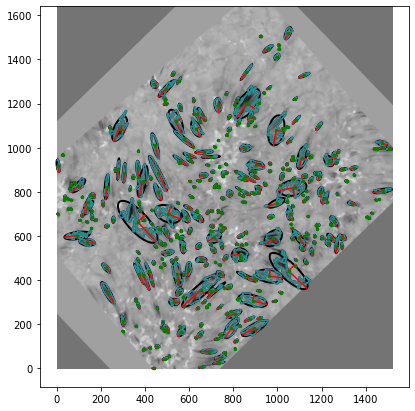

In [28]:
import math
import matplotlib.patches as mpatches
for time in range(3): 
#     time = time+164
    fig, ax = plt.subplots(figsize=(7,7))
    reference_mask = morph_processed_blue[:,:,time]
    label_2d = label(reference_mask,connectivity=2,return_num=True)
    ax.imshow(cubeH[:,:,time,9],origin='lower',cmap='Greys_r')#,extent=[0,56,0,61])
    ax.contour(reference_mask,levels=1,origin='lower')
    for region in regionprops(label_2d[0]):
        y0,x0 = region.centroid
        orientation = region.orientation
        angle = math.degrees(orientation)
        x1 = x0 + math.cos(orientation) * 0.5 * region.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.major_axis_length
        ax.plot((x0, x1), (y0, y1), '-r')
        ax.plot((x0, x2), (y0, y2), '-r')
        ax.plot(x0, y0, '.g', markersize=5)
        ellipse = mpatches.Ellipse((x0, y0), region.minor_axis_length, region.major_axis_length,
                                      fill=False, edgecolor='black', linewidth=2,angle=-angle)
        ax.add_patch(ellipse)


In [11]:
#to resort to default params after you have used plt.style.use()
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

In [11]:
#chosing the best image based on RMS contrast
contrast =[]
for scan in range(425):
    contrast1= np.std(cubeH[100:1400,100:1400,scan,9]/np.mean(cubeH[100:1400,100:1400,scan,9]))
    contrast.append(contrast1)

In [12]:
contrast = np.array(contrast)
best = np.argmax(contrast)

Text(0, 0.5, 'RMS contrast')

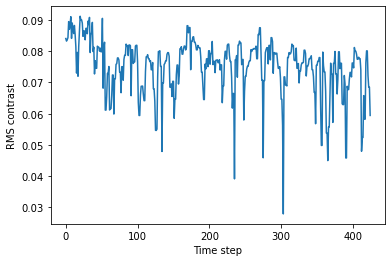

In [13]:
plt.plot(contrast)
plt.xlabel('Time step')
plt.ylabel('RMS contrast')

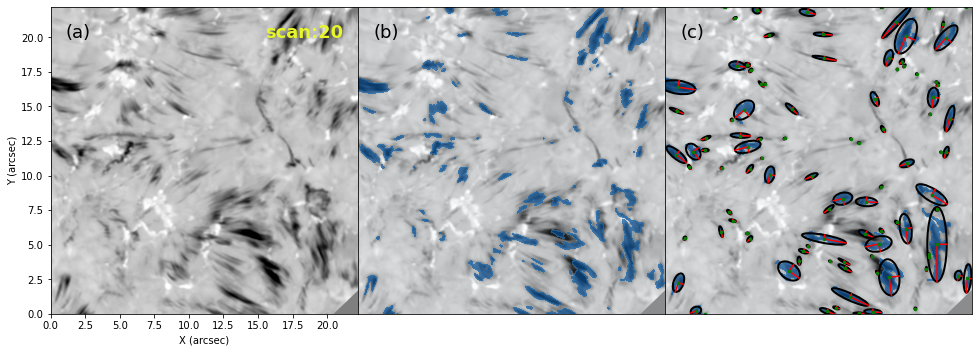

In [14]:
#plt.style.use('classic')
import math
import matplotlib.patches as mpatches
scan=20
fig, ax = plt.subplots(1,3,figsize=(16,5.33))
fig.subplots_adjust(wspace=0,left=0.1,right=0.9,top=0.9,bottom=0.1)
ax=ax.ravel()
ax[0].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[0].set_ylabel('Y (arcsec)')
ax[0].set_xlabel('X (arcsec)')
ax[0].text(.05, .9, '(a)', transform=ax[0].transAxes, fontsize=18,color='black')
ax[0].text(.7, .9, 'scan:20', transform=ax[0].transAxes, fontsize=18,color='#E7F52B',weight='bold')
label_2d = label(morph_processed_blue[400:1000,600:1200,scan],connectivity=2,return_num=True)
mask_2d = label_2d[0]*0
mask_2d[np.where(label_2d[0]!=0)]=1.
ax[1].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[1].contourf(mask_2d,levels=2,cmap=mycmap,extent=[0,600*0.037,0,600*0.037],origin='lower')
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)   
ax[1].text(.05, .9, '(b)', transform=ax[1].transAxes, fontsize=18,color='black')
ax[2].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',vmax=28000,vmin=5000)
ax[2].contourf(mask_2d,levels=2,cmap=mycmap,origin='lower')
ax[2].text(.05, .9, '(c)', transform=ax[2].transAxes, fontsize=18,color='black')
for region in regionprops(label_2d[0]):
    y0,x0 = region.centroid
    orientation = region.orientation
    angle = math.degrees(orientation)
    x1 = x0 + math.cos(orientation) * 0.5 * region.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * region.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * region.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * region.major_axis_length
    ax[2].plot((x0, x1), (y0, y1), '-r')
    ax[2].plot((x0, x2), (y0, y2), '-r')
    ax[2].plot(x0, y0, '.g', markersize=5)
    ellipse = mpatches.Ellipse((x0, y0), region.minor_axis_length, region.major_axis_length,
                                  fill=False, edgecolor='black', linewidth=2,angle=-angle)
    ax[2].add_patch(ellipse)

ax[2].axis((0,600,0,600))
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)    
#plt.contourf(morph_processed_blue[:,:,100],levels=2,cmap=mycmap)
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/Ellipse_fit_sample.pdf',dpi=300)
plt.show()

## Figure for discussing the method of performing the labeling

In [15]:
labeled_3d = label(morph_processed_blue, connectivity=2)

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


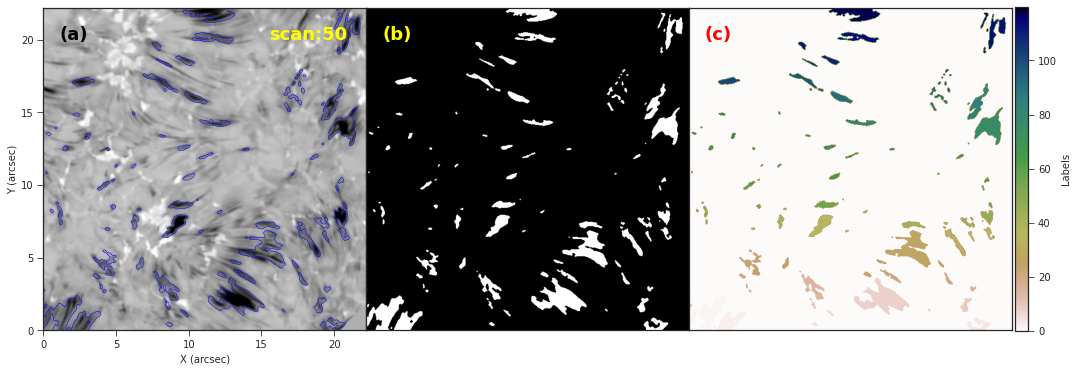

In [26]:
plt.style.use('seaborn-ticks')
import matplotlib as mpl
scan=50
fig, ax = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0,left=0.1,right=0.9,top=0.9,bottom=0.1)
ax=ax.ravel()
ax[0].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[0].set_ylabel('Y (arcsec)')
ax[0].set_xlabel('X (arcsec)')
ax[0].set_xticks([0,5,10,15,20])
ax[0].set_yticks([0,5,10,15,20])
ax[0].contour(morph_processed_blue[400:1000,600:1200,scan],origin='lower',levels=[10],colors=['blue'],linewidths=[0.5],extent=[0,600*0.037,0,600*0.037])
ax[0].text(.05, .9, '(a)', transform=ax[0].transAxes, fontsize=18,color='black',weight='bold')
ax[0].text(.7, .9, 'scan:50', transform=ax[0].transAxes, fontsize=18,color='yellow',weight='bold')
ax[1].imshow(morph_processed_blue[400:1000,600:1200,scan],origin='lower',cmap='gray')
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)   
ax[1].text(.05, .9, '(b)', transform=ax[1].transAxes, fontsize=18,color='yellow',weight='bold')
label_2d_1 = label(morph_processed_blue[400:1000,600:1200,scan],connectivity=2)
ax[2].imshow(label_2d_1,cmap='gist_earth_r',origin='lower',extent=[0,600*0.037,0,600*0.037])
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)   
ax[2].text(.05, .9, '(c)', transform=ax[2].transAxes, fontsize=18,color='red',weight='bold')
cmap = mpl.cm.gist_earth_r
fig.subplots_adjust(right=0.847)
cbar_ax = fig.add_axes([0.85, 0.125, 0.01, 0.75])#[left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm)
cb1.set_ticks([0,0.167,0.167*2,0.167*3, 0.167*4, 0.167*5])
cb1.set_ticklabels(["0", "20","40","60","80","100"])
cb1.set_label('Labels')
plt.show()
#plt.savefig('/mn/stornext/d9/souvikb/paper4_images/detection_sample.pdf',dpi=300)

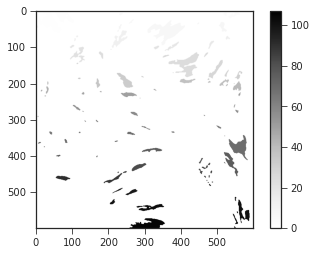

In [18]:
plt.imshow(label_2d_1)
plt.colorbar()

In [22]:
label_2d_1.max()/6

17.833333333333332

In [25]:
1/6.

0.16666666666666666

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


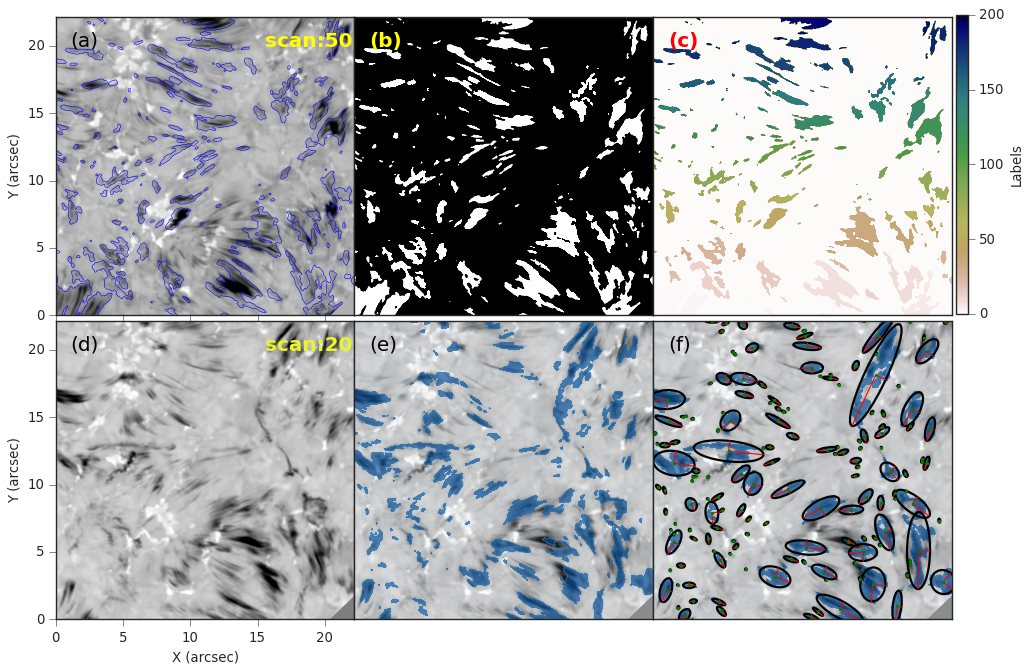

In [178]:
fig, ax =plt.subplots(2,3,figsize=(15,9.5),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.0,wspace=0.00,left=0.1,right=0.9,top=0.9,bottom=0.1)
ax=ax.ravel()
scan=50
ax[0].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[0].set_ylabel('Y (arcsec)')
ax[0].set_xlabel('X (arcsec)')
#ax[0].set_xticks([0,5,10,15,20])
ax[0].xaxis.set_visible(False)
ax[0].contour(morph_processed_blue[400:1000,600:1200,scan],origin='lower',levels=[10],colors=['blue'],linewidths=[0.5],extent=[0,600*0.037,0,600*0.037])
ax[0].text(.05, .9, '(a)', transform=ax[0].transAxes, fontsize=18,color='black')
ax[0].text(.7, .9, 'scan:50', transform=ax[0].transAxes, fontsize=18,color='yellow',weight='bold')
ax[1].imshow(morph_processed_blue[400:1000,600:1200,scan],origin='lower',cmap='gray')
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)   
ax[1].text(.05, .9, '(b)', transform=ax[1].transAxes, fontsize=18,color='yellow',weight='bold')
label_2d_1 = label(morph_processed_blue[400:1000,600:1200,scan],connectivity=2)
ax[2].imshow(label_2d_1,cmap='gist_earth_r',origin='lower',extent=[0,600*0.037,0,600*0.037])
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)   
ax[2].text(.05, .9, '(c)', transform=ax[2].transAxes, fontsize=18,color='red',weight='bold')
cmap = mpl.cm.gist_earth_r
fig.subplots_adjust(right=0.847)
cbar_ax = fig.add_axes([0.85, 0.505, 0.01, 0.394])#[left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm)
cb1.set_ticks([0,0.25,0.5,0.75, 1])
cb1.set_ticklabels(["0", "50","100","150","200"])
cb1.set_label('Labels')

scan=20
ax[3].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[3].set_ylabel('Y (arcsec)')
ax[3].set_xlabel('X (arcsec)')
ax[3].text(.05, .9, '(d)', transform=ax[3].transAxes, fontsize=18,color='black')
ax[3].text(.7, .9, 'scan:20', transform=ax[3].transAxes, fontsize=18,color='#E7F52B',weight='bold')
label_2d = label(morph_processed_blue[400:1000,600:1200,scan],connectivity=2,return_num=True)
mask_2d = label_2d[0]*0
mask_2d[np.where(label_2d[0]!=0)]=1.
ax[4].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[4].contourf(mask_2d,levels=2,cmap='Blues',extent=[0,600*0.037,0,600*0.037],origin='lower')
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)   
ax[4].text(.05, .9, '(e)', transform=ax[4].transAxes, fontsize=18,color='black')
ax[5].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',vmax=28000,vmin=5000)
ax[5].contourf(mask_2d,levels=2,cmap=mycmap,origin='lower')
ax[5].text(.05, .9, '(f)', transform=ax[5].transAxes, fontsize=18,color='black')
for region in regionprops(label_2d[0]):
    y0,x0 = region.centroid
    orientation = region.orientation
    angle = math.degrees(orientation)
    x1 = x0 + math.cos(orientation) * 0.5 * region.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * region.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * region.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * region.major_axis_length
    ax[5].plot((x0, x1), (y0, y1), '-r')
    ax[5].plot((x0, x2), (y0, y2), '-r')
    ax[5].plot(x0, y0, '.g', markersize=5)
    ellipse = mpatches.Ellipse((x0, y0), region.minor_axis_length, region.major_axis_length,
                                  fill=False, edgecolor='black', linewidth=2,angle=-angle)
    ax[5].add_patch(ellipse)

ax[5].axis((0,600,0,600))
ax[5].xaxis.set_visible(False)
ax[5].yaxis.set_visible(False)    

plt.savefig('/mn/stornext/d9/souvikb/paper4_images/combined_detection_ellipse.png',dpi=400)

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


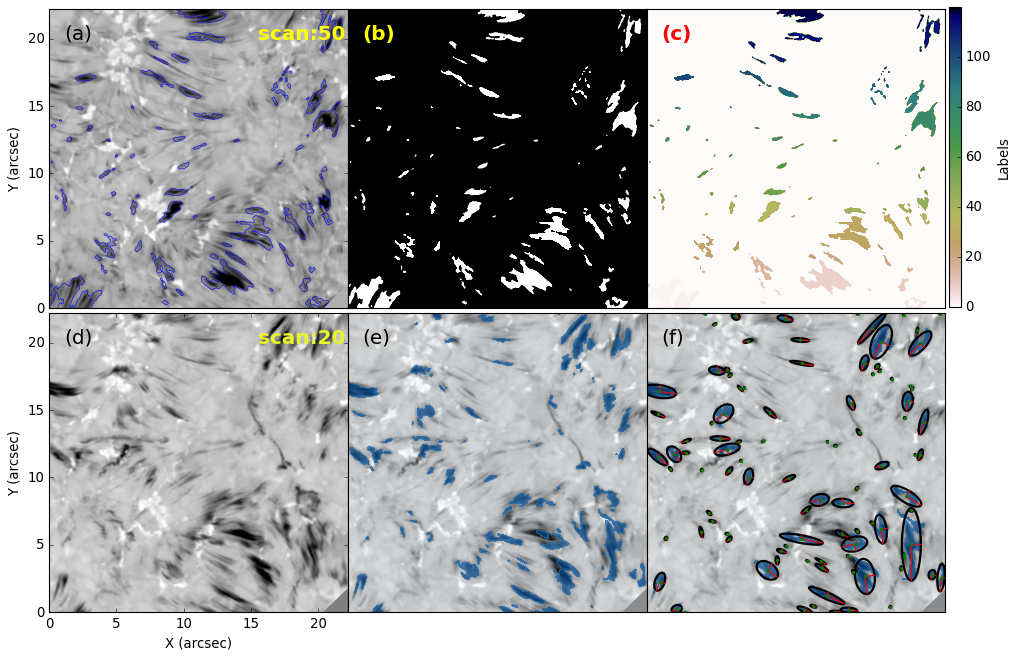

In [30]:
plt.style.use('classic')
fig, ax =plt.subplots(2,3,figsize=(15,9.5),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.0,wspace=0.00,left=0.1,right=0.9,top=0.9,bottom=0.1)
ax=ax.ravel()
scan=50
ax[0].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[0].set_ylabel('Y (arcsec)')
ax[0].set_xlabel('X (arcsec)')
#ax[0].set_xticks([0,5,10,15,20])
ax[0].xaxis.set_visible(False)
ax[0].contour(morph_processed_blue[400:1000,600:1200,scan],origin='lower',levels=[10],colors=['blue'],linewidths=[0.5],extent=[0,600*0.037,0,600*0.037])
ax[0].text(.05, .9, '(a)', transform=ax[0].transAxes, fontsize=18,color='black')
ax[0].text(.7, .9, 'scan:50', transform=ax[0].transAxes, fontsize=18,color='yellow',weight='bold')
ax[1].imshow(morph_processed_blue[400:1000,600:1200,scan],origin='lower',cmap='gray')
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)   
ax[1].text(.05, .9, '(b)', transform=ax[1].transAxes, fontsize=18,color='yellow',weight='bold')
label_2d_1 = label(morph_processed_blue[400:1000,600:1200,scan],connectivity=2)
ax[2].imshow(label_2d_1,cmap='gist_earth_r',origin='lower',extent=[0,600*0.037,0,600*0.037])
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)   
ax[2].text(.05, .9, '(c)', transform=ax[2].transAxes, fontsize=18,color='red',weight='bold')
cmap = mpl.cm.gist_earth_r
fig.subplots_adjust(right=0.847)
cbar_ax = fig.add_axes([0.85, 0.505, 0.01, 0.394])#[left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm)
cb1.set_ticks([0,0.167,0.167*2,0.167*3, 0.167*4, 0.167*5])
cb1.set_ticklabels(["0", "20","40","60","80","100"])
cb1.set_label('Labels')

scan=20
ax[3].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[3].set_ylabel('Y (arcsec)')
ax[3].set_xlabel('X (arcsec)')
ax[3].text(.05, .9, '(d)', transform=ax[3].transAxes, fontsize=18,color='black')
ax[3].text(.7, .9, 'scan:20', transform=ax[3].transAxes, fontsize=18,color='#E7F52B',weight='bold')
label_2d = label(morph_processed_blue[400:1000,600:1200,scan],connectivity=2,return_num=True)
mask_2d = label_2d[0]*0
mask_2d[np.where(label_2d[0]!=0)]=1.
ax[4].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[4].contourf(mask_2d,levels=2,cmap='Blues',extent=[0,600*0.037,0,600*0.037],origin='lower')
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)   
ax[4].text(.05, .9, '(e)', transform=ax[4].transAxes, fontsize=18,color='black')
ax[5].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',vmax=28000,vmin=5000)
ax[5].contourf(mask_2d,levels=2,cmap=mycmap,origin='lower')
ax[5].text(.05, .9, '(f)', transform=ax[5].transAxes, fontsize=18,color='black')
for region in regionprops(label_2d[0]):
    y0,x0 = region.centroid
    orientation = region.orientation
    angle = math.degrees(orientation)
    x1 = x0 + math.cos(orientation) * 0.5 * region.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * region.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * region.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * region.major_axis_length
    ax[5].plot((x0, x1), (y0, y1), '-r')
    ax[5].plot((x0, x2), (y0, y2), '-r')
    ax[5].plot(x0, y0, '.g', markersize=5)
    ellipse = mpatches.Ellipse((x0, y0), region.minor_axis_length, region.major_axis_length,
                                  fill=False, edgecolor='black', linewidth=2,angle=-angle)
    ax[5].add_patch(ellipse)

ax[5].axis((0,600,0,600))
ax[5].xaxis.set_visible(False)
ax[5].yaxis.set_visible(False)    

plt.savefig('/mn/stornext/d9/souvikb/paper4_images/combined_detection_ellipse_new.pdf',dpi=400)

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


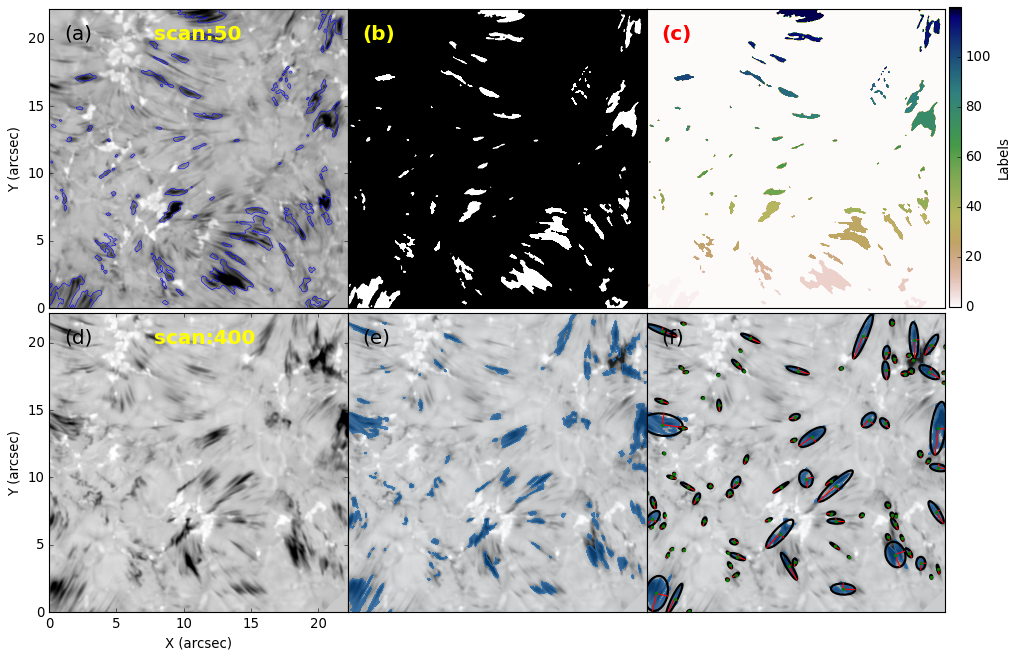

In [67]:
plt.style.use('classic')
fig, ax =plt.subplots(2,3,figsize=(15,9.5),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.0,wspace=0.00,left=0.1,right=0.9,top=0.9,bottom=0.1)
ax=ax.ravel()
scan=50
ax[0].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[0].set_ylabel('Y (arcsec)')
ax[0].set_xlabel('X (arcsec)')
#ax[0].set_xticks([0,5,10,15,20])
ax[0].xaxis.set_visible(False)
ax[0].contour(morph_processed_blue[400:1000,600:1200,scan],origin='lower',levels=[10],colors=['blue'],linewidths=[0.5],extent=[0,600*0.037,0,600*0.037])
ax[0].text(.05, .9, '(a)', transform=ax[0].transAxes, fontsize=18,color='black')
ax[0].text(.35, .9, 'scan:50', transform=ax[0].transAxes, fontsize=18,color='yellow',weight='bold')
ax[1].imshow(morph_processed_blue[400:1000,600:1200,scan],origin='lower',cmap='gray')
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)   
ax[1].text(.05, .9, '(b)', transform=ax[1].transAxes, fontsize=18,color='yellow',weight='bold')
label_2d_1 = label(morph_processed_blue[400:1000,600:1200,scan],connectivity=2)
ax[2].imshow(label_2d_1,cmap='gist_earth_r',origin='lower',extent=[0,600*0.037,0,600*0.037])
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)   
ax[2].text(.05, .9, '(c)', transform=ax[2].transAxes, fontsize=18,color='red',weight='bold')
cmap = mpl.cm.gist_earth_r
fig.subplots_adjust(right=0.847)
cbar_ax = fig.add_axes([0.85, 0.505, 0.01, 0.394])#[left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm)
cb1.set_ticks([0,0.167,0.167*2,0.167*3, 0.167*4, 0.167*5])
cb1.set_ticklabels(["0", "20","40","60","80","100"])
cb1.set_label('Labels')

scan=400
ax[3].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[3].set_ylabel('Y (arcsec)')
ax[3].set_xlabel('X (arcsec)')
ax[3].text(.05, .9, '(d)', transform=ax[3].transAxes, fontsize=18,color='black')
ax[3].text(.35, .9, 'scan:400', transform=ax[3].transAxes, fontsize=18,color='yellow',weight='bold')
label_2d = label(morph_processed_blue[400:1000,600:1200,scan],connectivity=2,return_num=True)
mask_2d = label_2d[0]*0
for region in regionprops(label_2d[0]):
    if region.major_axis_length*0.037*0.722 >=0.1:
        index = region.label
        mask_2d[np.where(label_2d[0]==index)]=1
    else:
        continue
        
#mask_2d[np.where(label_2d[0]!=0)]=1.

ax[4].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',extent=[0,600*0.037,0,600*0.037],vmax=28000,vmin=5000)
ax[4].contourf(mask_2d,levels=2,cmap='Blues',extent=[0,600*0.037,0,600*0.037],origin='lower')
ax[4].xaxis.set_visible(False)
ax[4].yaxis.set_visible(False)   
ax[4].text(.05, .9, '(e)', transform=ax[4].transAxes, fontsize=18,color='black')
ax[5].imshow(rescale_intensity(cubeH[400:1000,600:1200,scan,9]),origin='lower',cmap='Greys_r',vmax=28000,vmin=5000)
ax[5].text(.05, .9, '(f)', transform=ax[5].transAxes, fontsize=18,color='black')
ax[5].contourf(mask_2d,levels=2,cmap=mycmap,origin='lower')
for region in regionprops(label_2d[0]):
    if region.major_axis_length*0.037*0.722 >=0.1:
        y0,x0 = region.centroid
        orientation = region.orientation
        angle = math.degrees(orientation)
        x1 = x0 + math.cos(orientation) * 0.5 * region.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.major_axis_length
        ax[5].plot((x0, x1), (y0, y1), '-r')
        ax[5].plot((x0, x2), (y0, y2), '-r')
        ax[5].plot(x0, y0, '.g', markersize=5)
        ellipse = mpatches.Ellipse((x0, y0), region.minor_axis_length, region.major_axis_length,
                                  fill=False, edgecolor='black', linewidth=2,angle=-angle)
        ax[5].add_patch(ellipse)
    else:
        continue
ax[5].axis((0,600,0,600))
ax[5].xaxis.set_visible(False)
ax[5].yaxis.set_visible(False)    

plt.savefig('/mn/stornext/d9/souvikb/paper4_images/combined_detection_ellipse_length=0.1.pdf',dpi=400,bbox_inches = 'tight',pad_innches=0.1)